# Overview

- big ten
- methods
- acf pacf

In [16]:
import pandas as pd
import numpy as np
import os

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', category=UserWarning)

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

%matplotlib inline

## Data Collection

***

To collect historic stock quote data TD Ameritrade API was utilized. A custom function was built to query the API call per developer documentation provided by [TD Ameritrade](https://developer.tdameritrade.com/apis). **NOTE** the cell below will not run unless the API key defined in `../src/tda_api_tools.py` line 17 is changed per user's key. 

The function below will query data per API call based on [Get Price History](https://developer.tdameritrade.com/price-history/apis/get/marketdata/%7Bsymbol%7D/pricehistory), any parameters defined in API should be passed as **EXACT** kwargs, and output a pandas dataframe. 

In [ ]:
import src.tda_api_tools as tda

start = "2015-10-14 17:00:00" # start date of the data collection
end = "2020-12-17 18:00:00" # end date of the data collection 
symbol="SPY" #S&P500 symbol

tda.get_price_history(symbol, 
                      periodType="month", 
                      frequencyType="daily", 
                      frequency=1, 
                      startDate=start, 
                      endDate=end)

***

For the rest of this notebook, pre-collected data will be utilized. Please refer to `../notebooks/tdameritrade_api.ipynb` for more details

In [56]:
symbols=["SPY", "AAPL", "MSFT", "AMZN", "FB", "GOOGL", "GOOG", "BRK.B", "JNJ", "JPM", "V"] #big 10 symbols to collect
pricetype = "close"
analysis_date_start = "2018-12-18"
analysis_date_end = "2020-02-28"

## Autocorrelation (ACF) and Partial Autocorrelation (PACF) for ARIMA

ACF and PACF was plotted on approximately 1 year of stock market data betwen 2019-2020 on their **closing** prices. All ACF and PACF plot behaves the same where ACF has stead reduction over lags while PACF has a significant drop at lag order of 2. This will determine the starting point of ARIMA model as order of AR(2). 

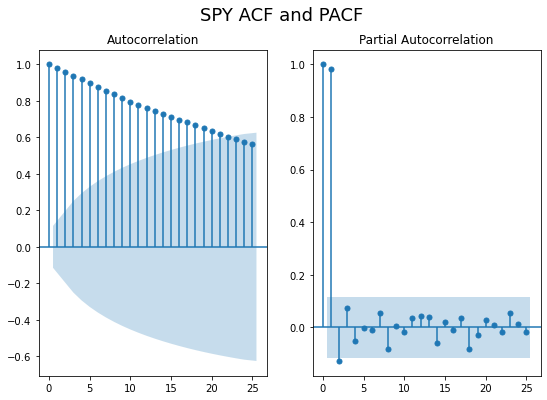

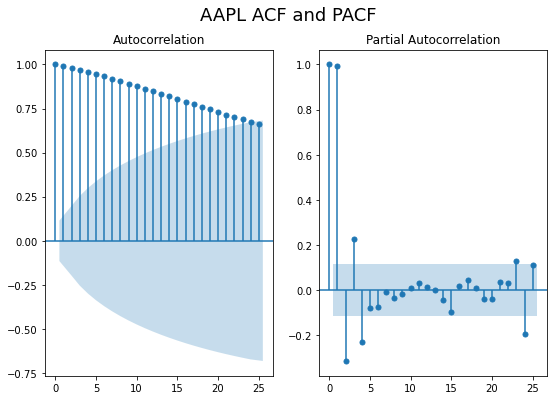

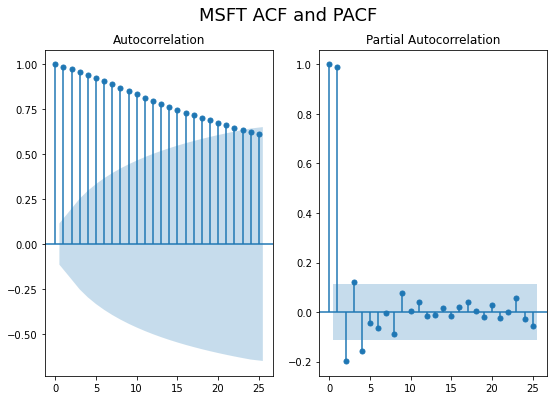

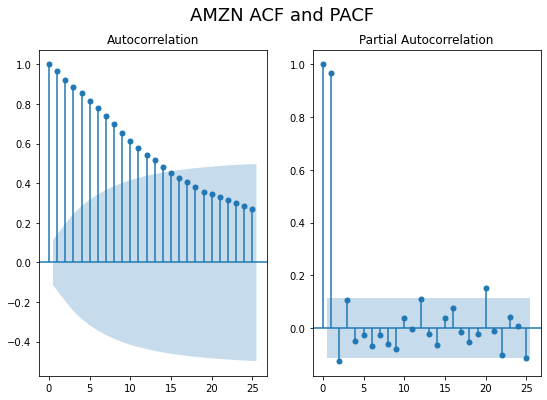

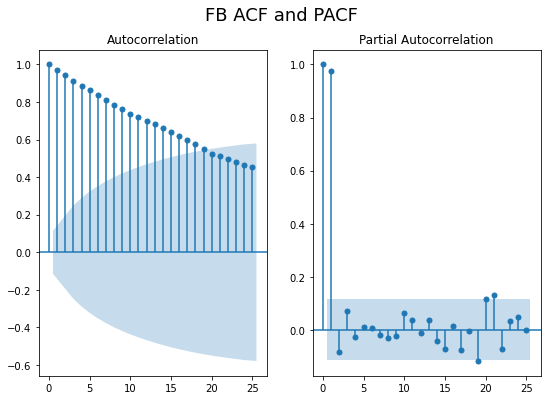

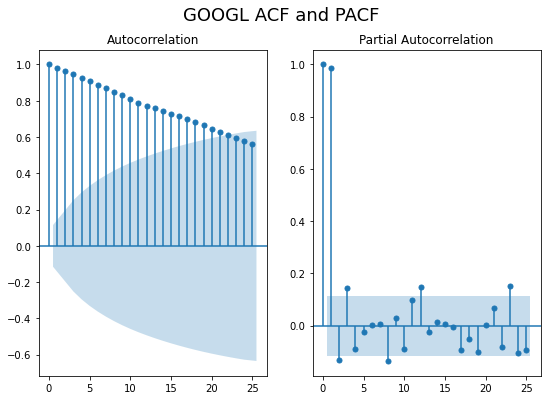

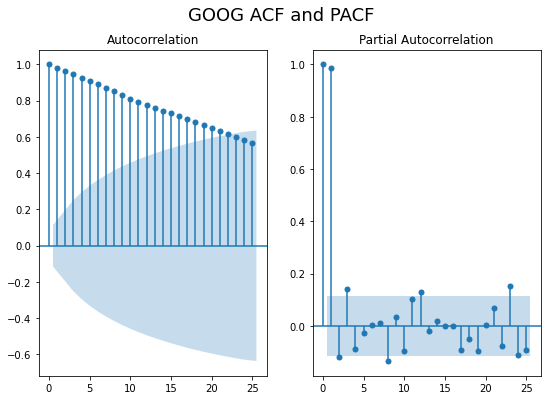

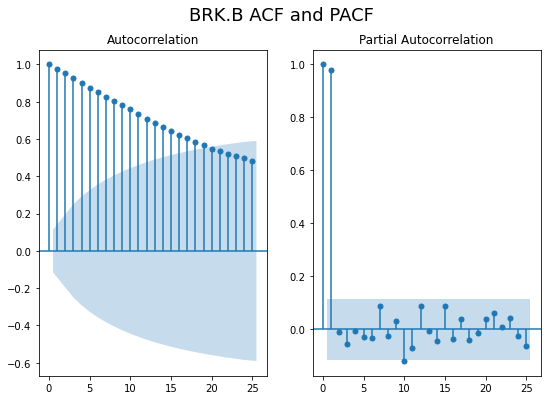

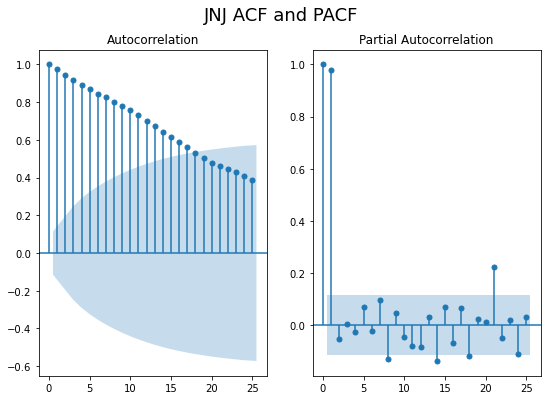

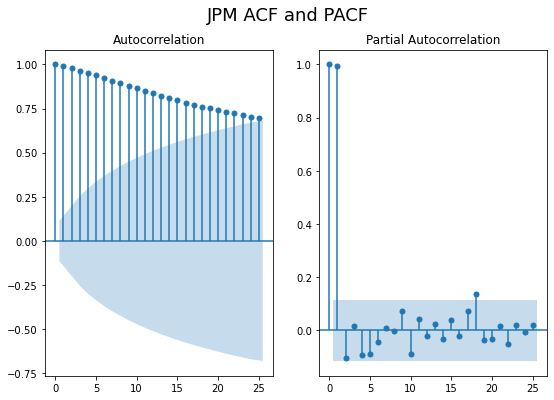

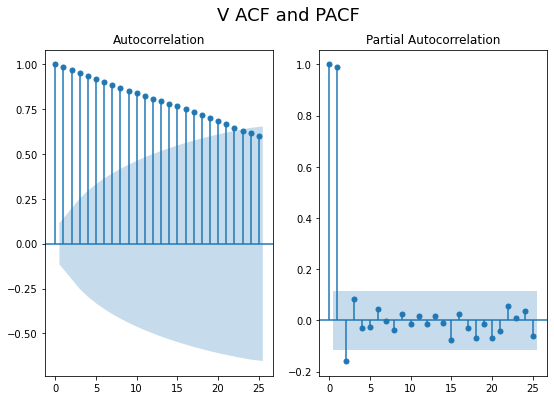

In [9]:
for symbol in symbols:
    filepath = "data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    plot_title = "{} ACF and PACF".format(symbol)
    fig, ax = plt.subplots(1,2, figsize=(9,6))
    plot_acf(stock_df.values, ax=ax[0]);
    plot_pacf(stock_df.values, ax=ax[1]);
    fig.suptitle(plot_title, size=18)

## GridSearch on ARIMA for Optimal Model Determination

PACF of all stock data so far provided a starting point of AR order of 2 for ARIMA model. Therefore, the optimal orders of Integration (I) and Moving Average (MA) through gridsearch iteration. The order of I will be between 0 and 1 and the order of MA will be between 1 and 2.

Some results may show that MA order of 0 providing the least amount of prediction error, but providing minimum order of 1 on MA model can reduce the "jumpiness" in the prediction allowing for more steady prediction. 

The gridsearch will be performed on the closing price of the data set on date range set previously and prediction will be made on 30 day range. 

Stock prices on Facebook(FB) will result in LU decomposition error, so the prediction for this model has been done separately.

The optimal values are determined by analyzing the grid search results. Following parameters are used:
- Model converges (TRUE)
- No warning flag present (0)
- Lowest RMSE values 

In [22]:
def ARIMA_gridsearch(p, d_max:int, q_max:int, data, prediction_length):
    return_list = [] #initialize return list
    train_data_idx = len(data) - prediction_length
    train = data[:train_data_idx] #slice train and test data
    test = data[train_data_idx:]
    d_range = range(0, d_max+1)
    q_range = range(1, q_max+1)
    for d in d_range:
        for q in q_range:
            model = ARIMA(train, order=(p,d,q)) #fit and predict
            arima_model = model.fit()
            model_prediction = arima_model.forecast(steps=prediction_length)
            warning = arima_model.mle_retvals["warnflag"]
            convergence = arima_model.mle_retvals["converged"]
            rmse_result = np.sqrt(mean_squared_error(test, model_prediction)) #get rmse
            return_list.append([p,d,q,convergence, warning, rmse_result])
    return sorted(return_list, key=lambda x: (x[-1], x[-2], (x[-3]*-1))) #order by RMSE, no warning, and convergence

In [26]:
symbols=["SPY", "AAPL", "MSFT", "AMZN", "GOOGL", "GOOG", "BRK.B", "JNJ", "JPM", "V"] #big 10 symbols to collect

In [27]:
for symbol in symbols:
    filepath = "data/{}_daily01.csv".format(symbol)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    grid_result = ARIMA_gridsearch(2, 1, 2, stock_df.values, 30)
    print(symbol)
    print(grid_result)

SPY
[[2, 1, 1, True, 0, 8.893556521107444], [2, 0, 1, True, 0, 9.001239487098836], [2, 1, 2, False, 1, 9.003816605240102], [2, 0, 2, True, 0, 9.008924806107492]]
AAPL
[[2, 0, 2, False, 1, 3.027925511225292], [2, 1, 1, True, 0, 3.0304678715248525], [2, 1, 2, True, 0, 3.038475312850803], [2, 0, 1, True, 0, 3.044015250538113]]
MSFT
[[2, 1, 1, True, 0, 15.170647185892438], [2, 1, 2, True, 0, 15.18037692336135], [2, 0, 2, True, 0, 15.70509499656263], [2, 0, 1, True, 0, 16.153351188784242]]
AMZN
[[2, 1, 1, True, 0, 173.1232728131126], [2, 1, 2, True, 0, 173.2374307713846], [2, 0, 2, True, 0, 191.6336661877257], [2, 0, 1, True, 0, 204.58442623045818]]
GOOGL
[[2, 1, 1, True, 0, 60.42202972627697], [2, 1, 2, True, 0, 60.573613712839396], [2, 0, 2, True, 0, 70.50163764561145], [2, 0, 1, True, 0, 83.42317788483938]]
GOOG
[[2, 1, 1, True, 0, 60.912609226203045], [2, 1, 2, True, 0, 61.08045632741628], [2, 0, 2, True, 0, 70.69948861498564], [2, 0, 1, True, 0, 83.20802817950067]]
BRK.B
[[2, 0, 1, Tru

#### Facebook GridSearch

In [28]:
filepath = "data/{}_daily01.csv".format("FB")
stock_df = pd.read_csv(filepath)
stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
grid_result = ARIMA_gridsearch(2, 1, 1, stock_df.values, 30)
print(symbol)
print(grid_result)

V
[[2, 0, 1, False, 1, 8.354210505691901], [2, 1, 1, True, 0, 10.86854927977906]]


Gridsearch Resulted in ARIMA order of 2, 1, 1 to be the most appropriate model for prediction of closing prices for all stocks except for JPM (JPMorgan Chase). For JPM, it was determined that order of 2, 0, 2 was most appropriate. 

### ARIMA Orders for all stocks

In [34]:
symbols=["SPY", "AAPL", "MSFT", "AMZN", "FB", "GOOGL", "GOOG", "BRK.B", "JNJ", "V", "JPM"] #big 10 symbols to collect
order_01 = [[2, 1, 1]] * (len(symbols)-1)
order_01.append([2, 0, 2])
ARIMA_orders = dict(zip(symbols, order_01))

In [35]:
ARIMA_orders

{'SPY': [2, 1, 1],
 'AAPL': [2, 1, 1],
 'MSFT': [2, 1, 1],
 'AMZN': [2, 1, 1],
 'FB': [2, 1, 1],
 'GOOGL': [2, 1, 1],
 'GOOG': [2, 1, 1],
 'BRK.B': [2, 1, 1],
 'JNJ': [2, 1, 1],
 'V': [2, 1, 1],
 'JPM': [2, 0, 2]}

## Model Fitting and Rolling Prediction

**NOTE** During prediction it was found that `GOOGL` has LU decomposition error during prediction, requiring a drop in int integration order of 0. 

In [59]:
# update google
ARIMA_orders["GOOGL"] = [2, 0, 1]

Working on SPY
Total RMSE Error on SPY Stock Prices
7.441906756970477
Working on AAPL
Total RMSE Error on AAPL Stock Prices
2.3489609959356232
Working on MSFT
Total RMSE Error on MSFT Stock Prices
3.9434475256878443
Working on AMZN
Total RMSE Error on AMZN Stock Prices
69.2178998349941
Working on FB
Total RMSE Error on FB Stock Prices
7.696375716744009
Working on GOOGL
Total RMSE Error on GOOGL Stock Prices
19.390436921549394
Working on GOOG
Total RMSE Error on GOOG Stock Prices
33.68657365564742
Working on BRK.B
Total RMSE Error on BRK.B Stock Prices
6.015512319933153
Working on JNJ
Total RMSE Error on JNJ Stock Prices
3.1617638358354085
Working on V
Total RMSE Error on V Stock Prices
5.55136151474919
Working on JPM
Total RMSE Error on JPM Stock Prices
2.441276579675348


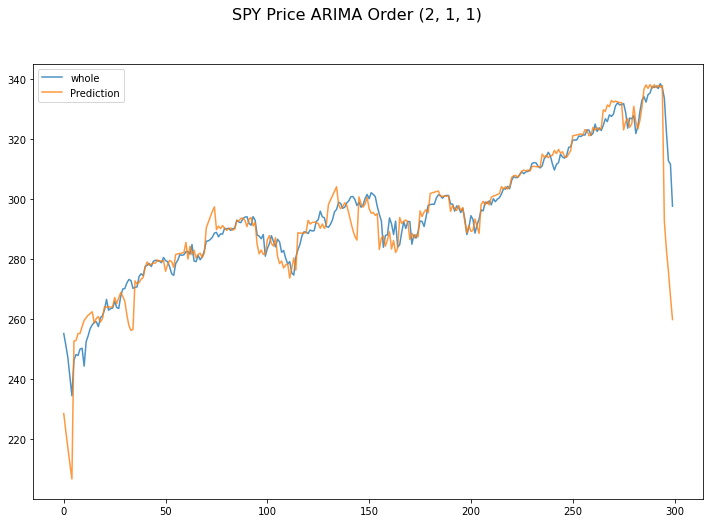

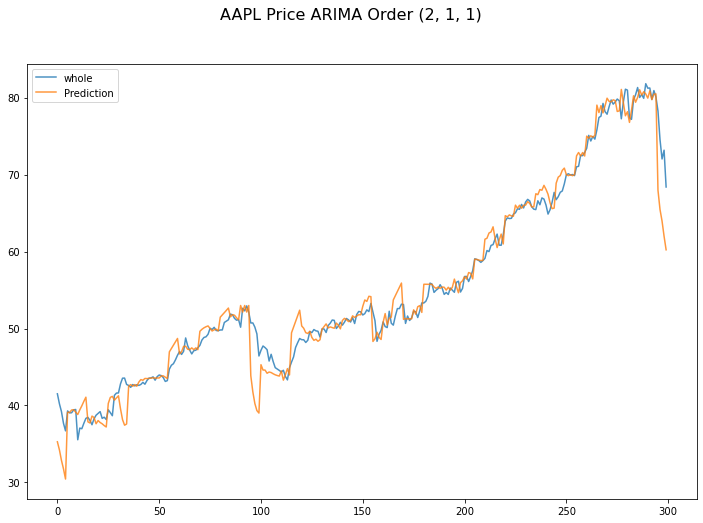

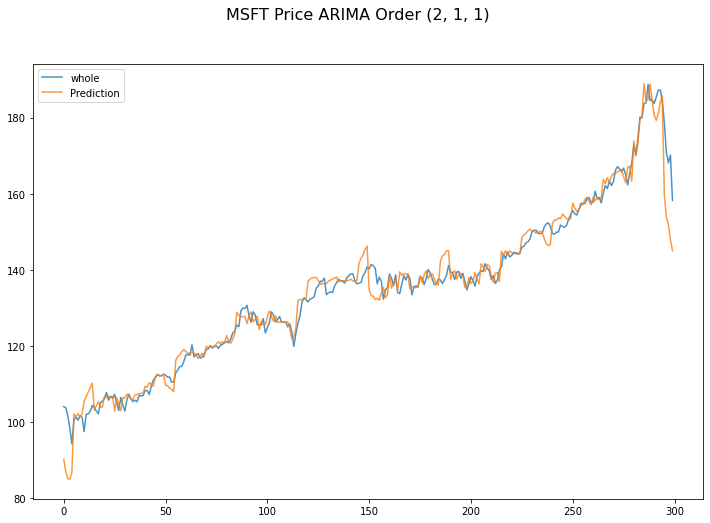

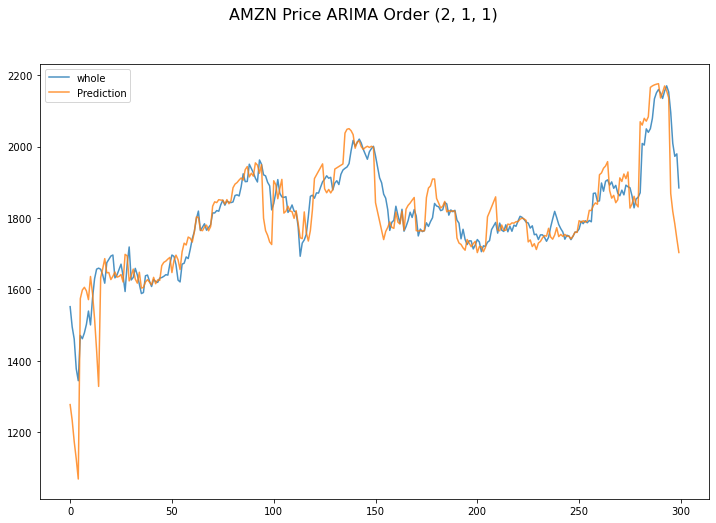

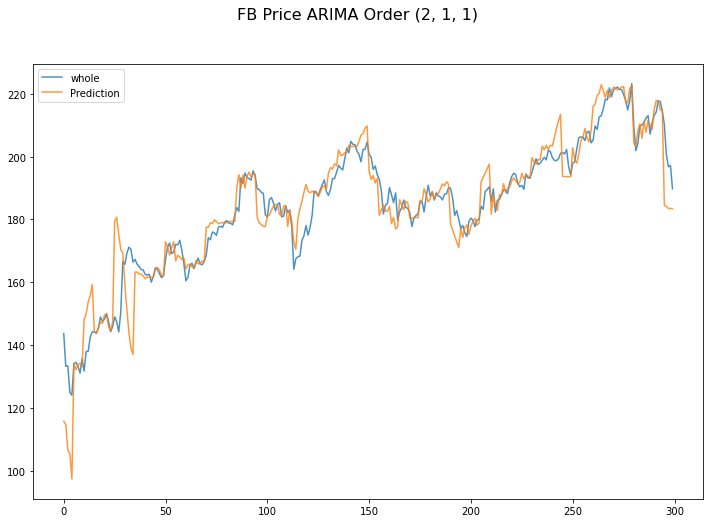

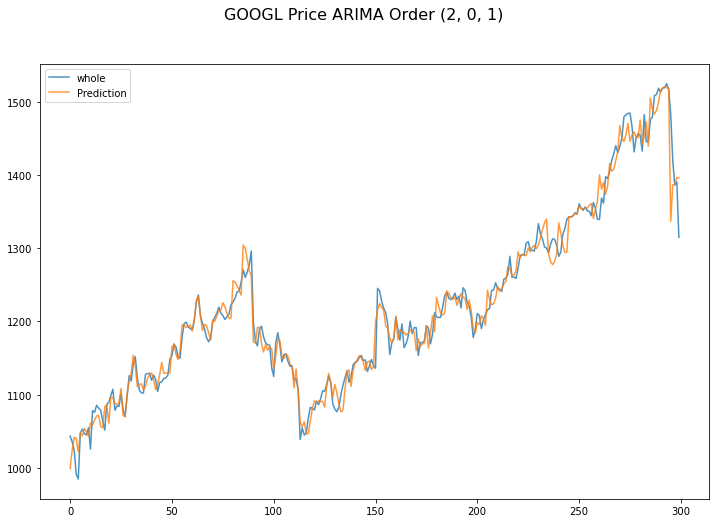

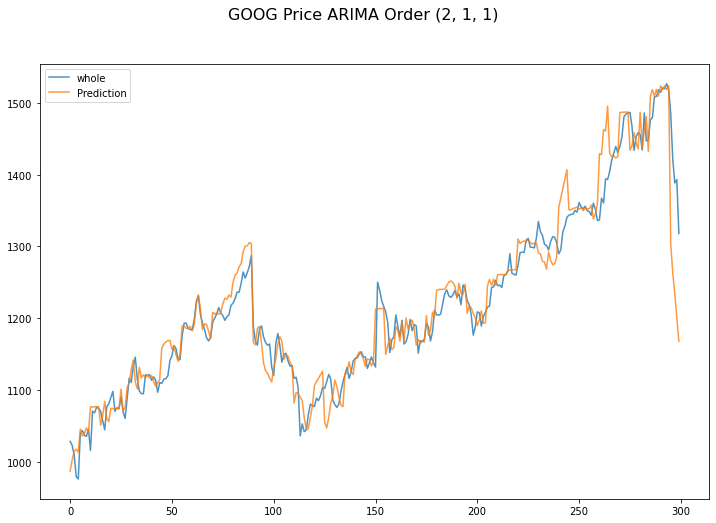

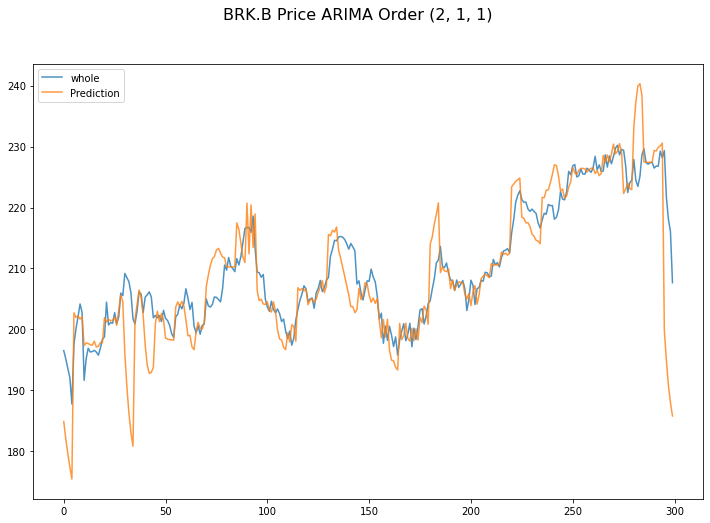

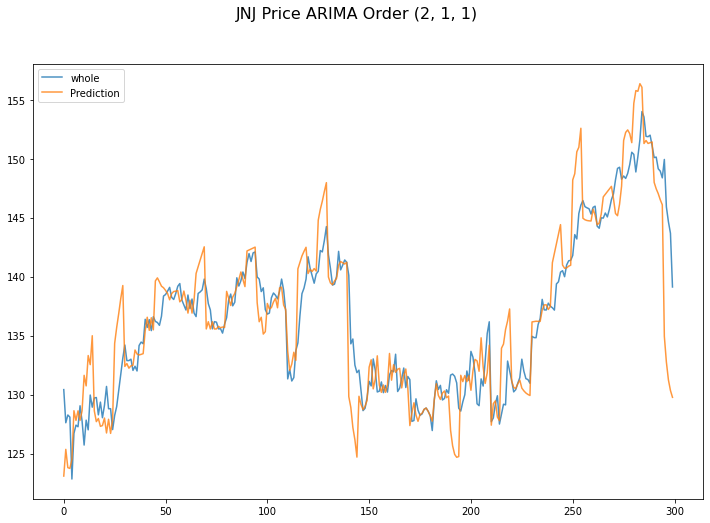

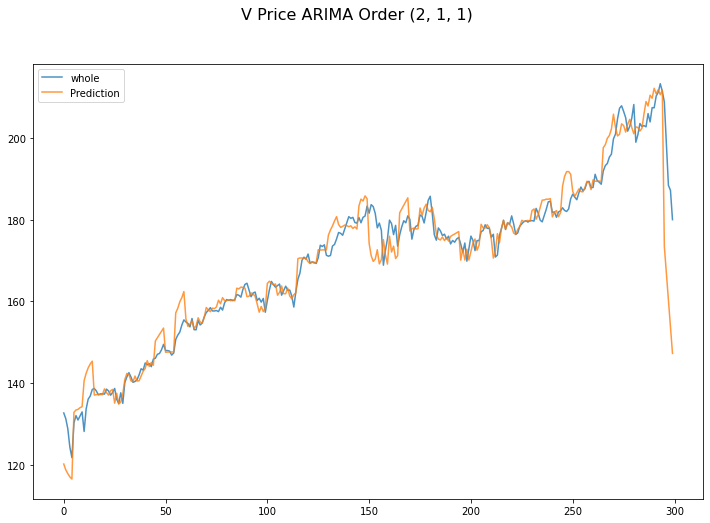

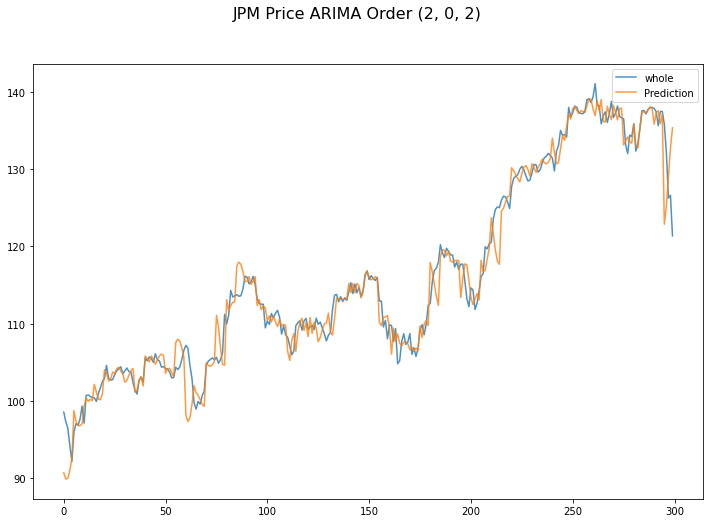

In [72]:
for key, values in ARIMA_orders.items():
    print("Working on {}".format(key))
    # get dataframe for relevant stocks
    filepath = "data/{}_daily01.csv".format(key)
    stock_df = pd.read_csv(filepath)
    stock_df = stock_df[(stock_df.to_datetime > analysis_date_start) & (stock_df.to_datetime < analysis_date_end)][pricetype]
    
    #intialize variables for rolling prediction
    rolling_pred = pd.Series(dtype="float64")
    rmse_dict = {}
    given_length = 25
    prediction_length = 5
    index=0
    p, d, q = values[0], values[1], values[2]
    
    
    while index < len(stock_df): #while loop for rolling prediction
        # slice training data
        index_stop = index + prediction_length
        train_data = stock_df[index:index_stop]
        # fit ARIMA Model per specification
        mod_arma = ARIMA(train_data, order=(p, d, q))
        res_arma = mod_arma.fit()
        #forecast and save data
        prediction = res_arma.forecast(steps=prediction_length)
        rolling_pred = pd.concat([rolling_pred, prediction])
        # keep on rolling
        index += prediction_length
    
    #reset indexes for plotting
    rolling_pred = rolling_pred.reset_index().drop(columns="index")
    stock_df = stock_df.reset_index().drop(columns="index")
    
    error = np.sqrt(mean_squared_error(stock_df, rolling_pred[:(stock_df.index[-1]+1)]))
    print("Total RMSE Error on {} Stock Prices".format(key))
    print(error)
    
    #save RMSE
    rmse_dict[key] = error
    
    #plot result
    fig, ax = plt.subplots(figsize=(12,8))
    
    stock = f"{key} Price"
    arima_order = f"ARIMA Order ({p}, {d}, {q})"  

    ax.plot(stock_df[rolling_pred.index[0]:], label="whole", alpha=0.8)
    ax.plot(rolling_pred, label="Prediction", alpha=0.8)
    fig.suptitle(" ".join([stock, arima_order]), size = 16)
    plt.legend()
    plt.savefig("images/{}_prediction.png".format(key))
